In this project I attempted to predict insurance charges based on a client's age, sex, BMI, smoking status, and region of residence. I started with simple linear models, then added polynomial and interaction terms. To compare models I used R squared and MSE. Smoking status appeared to be the most significant predictor of charges. Moreover, the interaction between smoking with age and BMI gave the best metrics, suggesting that smoking compounds the effects on charges caused by increasing age and BMI. However, my final model had inconsistent variance in residuals, meaning a lot of effects were left unexplained.

## Part 1: Data Exploration

1. Read in the dataset, and display some summaries of the data.

In [32]:
import pandas as pd

df = pd.read_csv("https://www.dropbox.com/s/bocjjyo1ehr5auz/insurance_costs_1.csv?dl=1")
df.head()

,age,sex,bmi,smoker,region,charges
0,19,female,27.900,yes,southwest,16884.92400
1,33,male,22.705,no,northwest,21984.47061
2,32,male,28.880,no,northwest,3866.85520
3,31,female,25.740,no,southeast,3756.62160
4,60,female,25.840,no,northwest,28923.13692


In [33]:
df.describe()

,age,bmi,charges
count,431.000000,431.000000,431.000000
mean,37.960557,30.768898,12297.098118
std,16.363909,6.111362,11876.527128
min,18.000000,15.960000,1131.506600
25%,22.000000,26.357500,2710.444575
50%,34.000000,30.590000,9866.304850
75%,55.000000,35.272500,14510.872600
max,64.000000,49.060000,55135.402090


In [34]:
df.isnull().sum()

age        0
sex        0
bmi        0
smoker     0
region     0
charges    0
dtype: int64

2. Fix any concerns you have about the data.

I'm concerned about the categorical variables so I'm going to dummify them. This converts categories like 'sex' and 'smoker' into numeric 0 or 1 columns that can be used in regression.

In [35]:
import pandas as pd
pd.get_dummies(df)

,age,bmi,charges,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
0,19,27.900,16884.92400,True,False,False,True,False,False,False,True
1,33,22.705,21984.47061,False,True,True,False,False,True,False,False
2,32,28.880,3866.85520,False,True,True,False,False,True,False,False
3,31,25.740,3756.62160,True,False,True,False,False,False,True,False
4,60,25.840,28923.13692,True,False,True,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...
426,23,33.400,10795.93733,True,False,True,False,False,False,False,True
427,18,31.920,2205.98080,True,False,True,False,True,False,False,False
428,18,36.850,1629.83350,True,False,True,False,False,False,True,False
429,21,25.800,2007.94500,True,False,True,False,False,False,False,True


In [36]:
X = pd.get_dummies(df)
X["smoker_no"] * 1

0      0
1      1
2      1
3      1
4      1
      ..
426    1
427    1
428    1
429    1
430    0
Name: smoker_no, Length: 431, dtype: int64

3. Make up to three plots comparing the response variable (charges) to one of the predictor variables. Briefly discuss each plot.

<Axes: xlabel='age', ylabel='charges'>

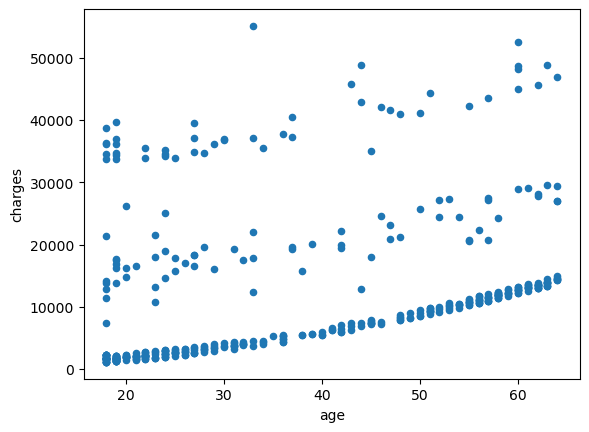

In [37]:
df.plot.scatter(x="age", y="charges")

There seems to be a correlation between age and higher charges. There are distinct groups of charges which could be explained by sex or smoking status, but all groups still increase with age. This suggests age is a useful predictor but there may be interaction effects with other variables.

<Axes: xlabel='bmi', ylabel='charges'>

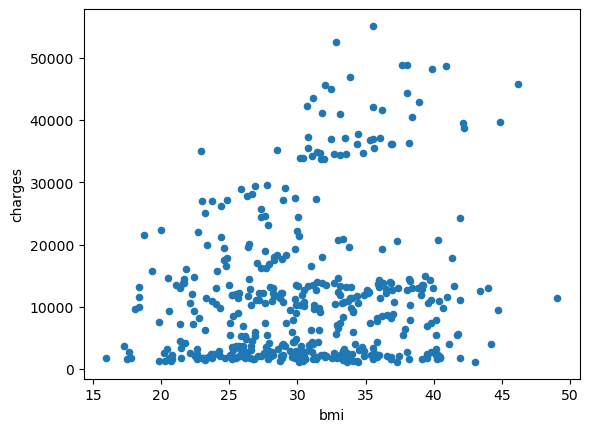

In [38]:
df.plot.scatter(x="bmi", y="charges")

There seems to be a weak correlation between higher BMI and charges. This is surprising because I would have expected to see an exponential relationship since health issues tend to compound with higher BMIs.

<Axes: title={'center': 'charges'}, xlabel='smoker'>

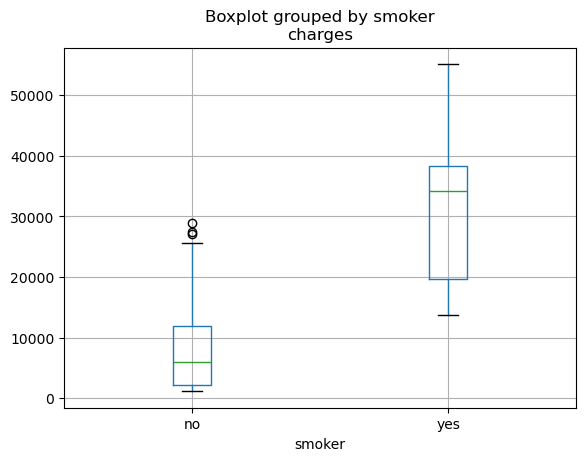

In [39]:
df.boxplot(column='charges', by='smoker')

Smokers have higher charges. No surprise, smoking is a major risk factor. The clear separation between groups suggests smoker status will be a strong predictor in our models.

## Part Two: Simple Linear Models

1. Construct a simple linear model to predict the insurance charges from the beneficiary’s age. Discuss the model fit, and interpret the coefficient estimates.

In [40]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

model_age = LinearRegression()

X=df[['age']]
y=df['charges']

model_age.fit(X,y)

model_age.coef_

array([228.79904937])

In [41]:
model_age.intercept_

np.float64(3611.758798507106)

In [42]:
pred_age = model_age.predict(df[['age']])
r2_age = r2_score(df['charges'], pred_age)
r2_age

0.09938105452062707

The model fit is very poor with a low R squared. The slope of 228 means charges increase by $228 per year of age. The intercept of $3,611 represents predicted charges at age zero, which could reflect baseline healthcare costs like birth or early childhood care.

2. Make a model that also incorporates the variable sex. Report your results.

In [43]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

df_dummy = pd.get_dummies(df[['age', 'sex']])

df_dummy.head()

,age,sex_female,sex_male
0,19,True,False
1,33,False,True
2,32,False,True
3,31,True,False
4,60,True,False


In [44]:
model_age_sex = LinearRegression()

X=df_dummy
y=df['charges']

model_age_sex.fit(X,y)
model_age.coef_

array([228.79904937])

In [45]:
model_age.intercept_

np.float64(3611.758798507106)

In [46]:
pred_age_sex = model_age_sex.predict(df_dummy)
r2_age_sex = r2_score(y, pred_age_sex)
r2_age_sex

0.10012952499706396

3. Now make a model that does not include sex, but does include smoker. Report your results

In [47]:
df_dummy_smoker = pd.get_dummies(df[['age', 'smoker']])

df_dummy_smoker.head()

,age,smoker_no,smoker_yes
0,19,False,True
1,33,True,False
2,32,True,False
3,31,True,False
4,60,True,False


In [48]:
model_age_smoker = LinearRegression()

X=df_dummy_smoker
y=df['charges']

model_age_smoker.fit(X,y)
model_age_smoker.coef_

array([   253.14535549, -12024.43371898,  12024.43371898])

In [49]:
model_age_smoker.intercept_

np.float64(9857.581423601505)

In [50]:
pred_age_smoker = model_age_smoker.predict(df_dummy_smoker)
r2_age_smoker = r2_score(y, pred_age_smoker)
r2_age_smoker

0.7603842948069404

4. Which model (Q2 or Q3) do you think better fits the data? Justify your answer by calculating the MSE for each model, and also by comparing R-squared values.

In [51]:
from sklearn.metrics import mean_squared_error, r2_score

mse_age_sex = mean_squared_error(df['charges'], pred_age_sex)
mse_age_sex

126633939.67937087

In [52]:
r2_age_smoker

0.7603842948069404

In [53]:
mse_age_smoker = mean_squared_error(df['charges'], pred_age_smoker)
mse_age_smoker

33719831.46524373

In [54]:
r2_age_sex

0.10012952499706396

The Q3 model (with smoker) is better because the R squared is much higher and the MSE is much lower. This makes sense since smoking status clearly separates the data into distinct groups with diffrent charges.

## Part Three: Multiple Linear Models

1. Fit a model that uses age and bmi as predictors. (Do not include an interaction term, age*bmi, between these two.) Report your results. How does the MSE compare to the model in Part Two Q1? How does the R-squared compare?

In [55]:
X = df[["age", "bmi"]]
y = df["charges"]

model = LinearRegression()
model.fit(X, y)

model.intercept_

np.float64(-4627.533445708483)

In [56]:
model.coef_

array([216.29721472, 283.20380126])

In [57]:
pred_age_bmi = model.predict(X)
mse_age_bmi = mean_squared_error(y, pred_age_bmi)
mse_age_bmi

123792439.58129103

In [58]:
r2_age_bmi = r2_score(y, pred_age_bmi)
r2_age_bmi

0.12032144234129338

In [59]:
pred_age = model_age.predict(df[['age']])
r2_age = r2_score(df['charges'], pred_age)
r2_age

0.09938105452062707

The MSE increases a lot while the R squared increases only slightly compared to Part Two Q1. Adding BMI as a predictor doesn't improve the model much, suggesting BMI alone isn't a strong predictor of charges.

2. Perhaps the relationships are not linear. Fit a model that uses age and age^2 as predictors. How do the MSE and R-squared compare to the model in P2 Q1?

In [60]:
df["age_sq"] = df["age"] ** 2

X = df[["age", "age_sq"]]
y = df["charges"]

model_age_sq = LinearRegression()
model_age_sq.fit(X, y)

model_age_sq.intercept_

np.float64(2299.7305687266908)

In [61]:
model_age_sq.coef_

array([308.42816984,  -1.00150889])

In [62]:
y_pred_age_sq = model_age_sq.predict(X)
mse_age_sq = mean_squared_error(y, y_pred_age_sq)
mse_age_sq

126710293.80956802

In [63]:
r2_age_sq = r2_score(y, y_pred_age_sq)
r2_age_sq

0.09958694669946933

R squared for P2 Q1 was 0.099 and MSE was 123,792,439. The nonlinear model with age and age squared has nearly identical metrics, so both work equally well. Adding the squared term doesn't capture any additional pattern in the data.

3. Fit a polynomial model of degree 4. How do the MSE and R-squared compare to the model in P2 Q1?

In [64]:
df["age_sq"] = df["age"] ** 2
df["age_cube"] = df["age"] ** 3
df["age_4"] = df["age"] ** 4

X = df[["age", "age_sq", "age_cube", "age_4"]]
y = df["charges"]

model_age_deg4 = LinearRegression()
model_age_deg4.fit(X, y)

model_age_deg4.intercept_

np.float64(68637.89783101245)

In [65]:
model_age_deg4.coef_

array([-7.94841022e+03,  3.58110163e+02, -6.47905090e+00,  4.12933982e-02])

In [66]:
y_pred_age_deg4 = model_age_deg4.predict(X)

mse_age_deg4 = mean_squared_error(y, y_pred_age_deg4)
mse_age_deg4

125550389.64569828

In [67]:
r2_age_deg4 = r2_score(y, y_pred_age_deg4)
r2_age_deg4

0.10782931453183786

R squared for P2 Q1 (age and BMI on charges) was 0.099 and MSE was 123,792,439. The degree 4 polynomial R squared is slightly better at 0.108, but MSE got worse. The pros and cons cancel each other out, so there's no real advantage to using the more complex model.

4. Fit a polynomial model of degree 12. How do the MSE and R-squared compare to the model in P2 Q1?

In [68]:
df["age_sq"] = df["age"] ** 2
df["age_cube"] = df["age"] ** 3
df["age_4"] = df["age"] ** 4
df["age_5"] = df["age"] ** 5
df["age_6"] = df["age"] ** 6
df["age_7"] = df["age"] ** 7
df["age_8"] = df["age"] ** 8
df["age_9"] = df["age"] ** 9
df["age_10"] = df["age"] ** 10
df["age_11"] = df["age"] ** 11
df["age_12"] = df["age"] ** 12

X = df[["age", "age_sq", "age_cube", "age_4", "age_5", "age_6", "age_7", "age_8", "age_9", "age_10", "age_11", "age_12"]]
y = df["charges"]

model_age_deg12 = LinearRegression()
model_age_deg12_fitted = model_age_deg12.fit(X, y)

model_age_deg12.intercept_

np.float64(7452.2823451165605)

In [69]:
model_age_deg12.coef_

array([ 3.04916819e-12,  8.39792599e-11,  3.46360971e-09,  7.55961594e-08,
        1.26243832e-06,  1.25112272e-05, -2.08396674e-08, -1.85914353e-08,
        4.09818451e-10, -2.52044337e-12, -1.01992348e-17,  1.42766008e-16])

In [70]:
y_pred_age_deg12 = model_age_deg12_fitted.predict(X)

mse_age_deg12 = mean_squared_error(y, y_pred_age_deg12)
mse_age_deg12

125373053.69367324

In [71]:
r2_age_deg12 = r2_score(y, y_pred_age_deg12)
r2_age_deg12

0.10908947739013564

R squared stays basically the same and MSE increases. This is not a better fit. The higher degree polynomial probably overfitted on training data, increasing MSE without capturing any more of the effect of age and so not increasing R squared. 

5. According to the MSE and R-squared, which is the best model? Do you agree that this is indeed the “best” model? Why or why not?

I don't agree that any single model is definitively 'best.' The metrics are pretty similar for all of them, and user specific requirements could mean that for some people one model is better than another. Simpler models are often preferred when performance is similar.

6. Plot the predictions from your model in Q4 as a line plot on top of the scatterplot of your original data.

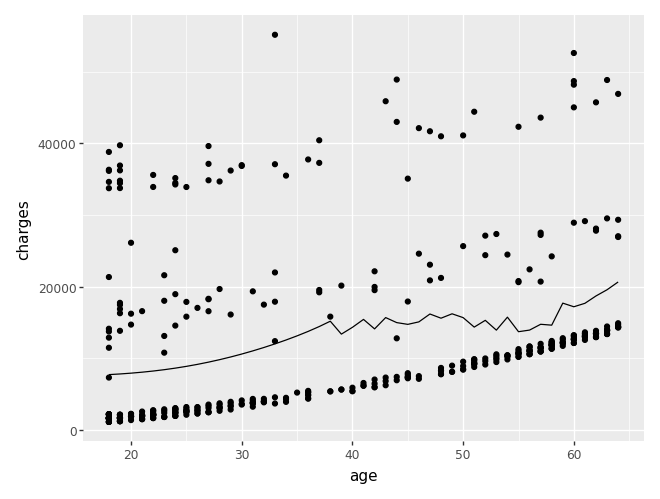

In [ ]:
import numpy as np
import pandas as pd
from plotnine import ggplot, geom_point, geom_line, aes

df['preds'] = y_pred_age_deg12

ggplot(df, aes(x= "age", y="charges")) + geom_point() + geom_line(aes(x="age", y="preds"))

## Part Four: New data

In [73]:
import pandas as pd

df_new = pd.read_csv("https://www.dropbox.com/s/sky86agc4s8c6qe/insurance_costs_2.csv?dl=1")
df_new.head()

,age,sex,bmi,smoker,region,charges
0,23,male,34.400,no,southwest,1826.84300
1,56,male,40.300,no,southwest,10602.38500
2,18,male,34.100,no,southeast,1137.01100
3,63,female,23.085,no,northeast,14451.83515
4,63,male,28.310,no,northwest,13770.09790


Age only

In [74]:
X_age = df[["age"]]
y = df["charges"]

model_age = LinearRegression()
model_age.fit(X_age, y)

y_pred_new_age = model_age.predict(df_new[["age"]])
mse_age_new = mean_squared_error(df_new["charges"], y_pred_new_age)
mse_age_new

136077136.50195494

Age and BMI

In [75]:
X_age_bmi = df[["age", "bmi"]]

model_age_bmi = LinearRegression()
model_age_bmi.fit(X_age_bmi, y)

y_pred_new_age_bmi = model_age_bmi.predict(df_new[["age", "bmi"]])
mse_age_bmi_new = mean_squared_error(df_new["charges"], y_pred_new_age_bmi)
mse_age_bmi_new

132636406.1108129

Age, BMI, smoker

In [76]:
df_dummy = pd.get_dummies(df[["smoker"]])
df_new_dummy = pd.get_dummies(df_new[["smoker"]])

X = pd.DataFrame()
X["age"] = df["age"]
X["bmi"] = df["bmi"]
X["smoker_yes"] = df_dummy["smoker_yes"]

X_new = pd.DataFrame()
X_new["age"] = df_new["age"]
X_new["bmi"] = df_new["bmi"]
X_new["smoker_yes"] = df_new_dummy["smoker_yes"]

In [77]:
model_age_bmi_smoker = LinearRegression()
model_age_bmi_smoker.fit(X, df["charges"])

LinearRegression()

In [78]:
y_pred_new = model_age_bmi_smoker.predict(X_new)

mse_age_bmi_smoker_new = mean_squared_error(df_new["charges"], y_pred_new)
mse_age_bmi_smoker_new

35377541.24141632

Age, bmi, and smoker, and age and bmi having an interaction with smoker

In [79]:
df_dummy = pd.get_dummies(df[["smoker"]])
df_new_dummy = pd.get_dummies(df_new[["smoker"]])

X_abc_full = pd.DataFrame()
X_abc_full["smoker_yes"] = df_dummy["smoker_yes"]
X_abc_full["age_smoker_yes"] = df["age"] * df_dummy["smoker_yes"]
X_abc_full["bmi_smoker_yes"] = df["bmi"] * df_dummy["smoker_yes"]
X_abc_full["age"] = df["age"]
X_abc_full["bmi"] = df["bmi"]

y = df["charges"]

model_abc_full = LinearRegression()
model_abc_full.fit(X_abc_full, y)

LinearRegression()

In [80]:
X_new_abc_full = pd.DataFrame()

X_new_abc_full["smoker_yes"] = df_new_dummy["smoker_yes"]
X_new_abc_full["age_smoker_yes"] = df_new["age"] * df_new_dummy["smoker_yes"]
X_new_abc_full["bmi_smoker_yes"] = df_new["bmi"] * df_new_dummy["smoker_yes"]
X_new_abc_full["age"] = df_new["age"]
X_new_abc_full["bmi"] = df_new["bmi"]


In [81]:
y_pred_new_abc_full = model_abc_full.predict(X_new_abc_full)

mse_abc_full_new = mean_squared_error(df_new["charges"], y_pred_new_abc_full)
mse_abc_full_new

21786256.86685256

The best model uses age, BMI, and smoker as predictors, with both quantitative variables having interaction terms with smoker. This allows the effect of age and BMI on charges to differ between smokers and non smokers, which matches the pattern we saw in our exploratory plots.

Below I made a residual plot to make sure the errors made in my model were random. The plot shows some issues. There's a curved pattern in the lower left, which means the model is missing a nonlinear relationship. The modles errors are way more all over the place for high charge people. Most larger residuals being positive indicate that we are chronically underestimating charges. This is not acceptable for steakholders. 

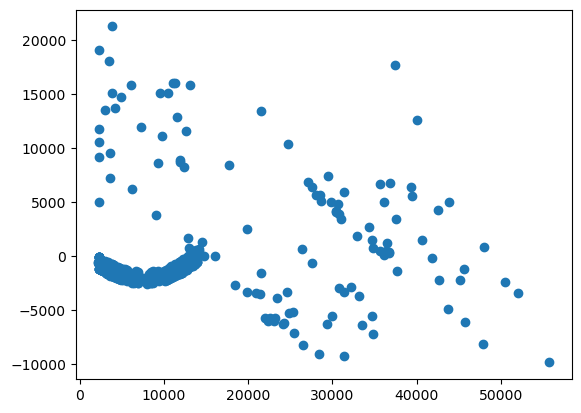

In [82]:
import matplotlib.pyplot as plt

y_pred_abc_full = model_abc_full.predict(X_abc_full)
residuals_abc_full = y - y_pred_abc_full

plt.scatter(y_pred_abc_full, residuals_abc_full)
plt.show()